<a href="https://colab.research.google.com/github/Htets-Corner/CIFAKE/blob/main/CIFAKE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Dataset download
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [20]:
import os

print("Dataset is stored at:", path)
print("Files:", os.listdir(path))


Dataset is stored at: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Files: ['test', 'train']


In [21]:
#Load Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.ImageFolder(root=os.path.join(path, "train"), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(path, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print("Train size:", len(train_data))
print("Test size:", len(test_data))
print("Classes:", train_data.classes)


Train size: 100000
Test size: 20000
Classes: ['FAKE', 'REAL']


In [22]:
#Define CNN Model
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # (3,32,32) → (32,32,32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # (32,32,32) → (64,32,32)
        self.pool = nn.MaxPool2d(2, 2)                # halves H,W
        self.fc1 = nn.Linear(64*8*8, 128)             # after 2 pools → 8x8
        self.fc2 = nn.Linear(128, 2)                  # 2 classes (FAKE, REAL)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (32,32,32) → (32,16,16)
        x = self.pool(F.relu(self.conv2(x)))   # (64,16,16) → (64,8,8)
        x = x.view(-1, 64*8*8)                 # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [26]:
#Training Loop and Testing Accuracy and Track the progress
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tracking lists
train_losses = []
test_losses = []
train_correct = []
test_correct = []

epochs = 10
for epoch in range(epochs):
    ########################
    # Training Phase
    ########################
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total

    train_losses.append(epoch_train_loss)
    train_correct.append(epoch_train_acc)

    ########################
    # Testing Phase
    ########################
    model.eval()
    test_running_loss = 0.0
    test_correct_count, test_total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track loss
            test_running_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct_count += (predicted == labels).sum().item()

    epoch_test_loss = test_running_loss / len(test_loader)
    epoch_test_acc = 100 * test_correct_count / test_total

    test_losses.append(epoch_test_loss)
    test_correct.append(epoch_test_acc)

    ########################
    # Epoch Summary
    ########################
    print(f"Epoch {epoch+1}/{epochs} "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch 1/10 Train Loss: 0.2543, Train Acc: 89.26% | Test Loss: 0.1888, Test Acc: 92.50%
Epoch 2/10 Train Loss: 0.1630, Train Acc: 93.59% | Test Loss: 0.1593, Test Acc: 93.62%
Epoch 3/10 Train Loss: 0.1319, Train Acc: 94.91% | Test Loss: 0.1419, Test Acc: 94.30%
Epoch 4/10 Train Loss: 0.1108, Train Acc: 95.71% | Test Loss: 0.1381, Test Acc: 94.83%
Epoch 5/10 Train Loss: 0.0937, Train Acc: 96.37% | Test Loss: 0.1347, Test Acc: 94.75%
Epoch 6/10 Train Loss: 0.0759, Train Acc: 97.07% | Test Loss: 0.1440, Test Acc: 94.86%
Epoch 7/10 Train Loss: 0.0608, Train Acc: 97.69% | Test Loss: 0.1516, Test Acc: 94.93%
Epoch 8/10 Train Loss: 0.0481, Train Acc: 98.19% | Test Loss: 0.1569, Test Acc: 95.11%
Epoch 9/10 Train Loss: 0.0392, Train Acc: 98.56% | Test Loss: 0.1782, Test Acc: 94.80%
Epoch 10/10 Train Loss: 0.0324, Train Acc: 98.79% | Test Loss: 0.1859, Test Acc: 94.91%
Training Took: 62.81236658891042 minutes!


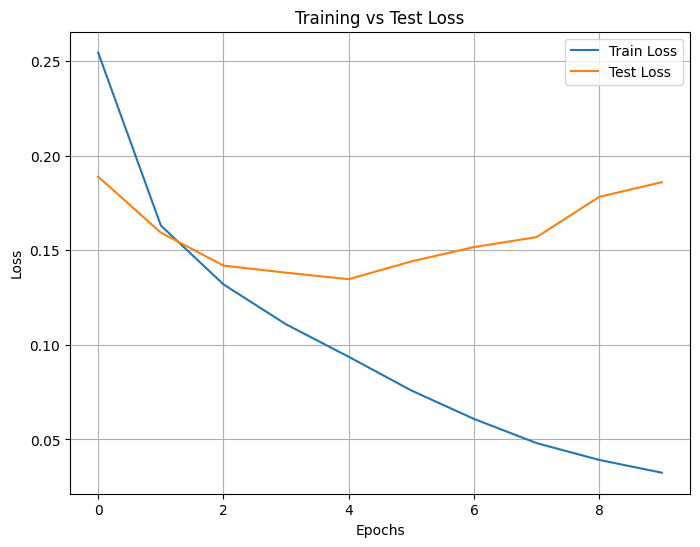

In [30]:
import matplotlib.pyplot as plt

# Plot Loss Curves
plt.figure(figsize=(8,6))
#plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()


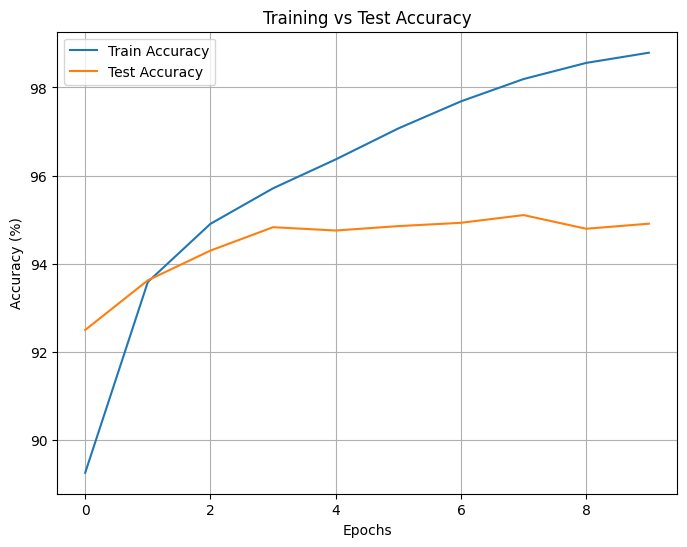

In [28]:
# Plot Accuracy Curves
plt.figure(figsize=(8,6))
plt.plot(train_correct, label='Train Accuracy')
plt.plot(test_correct, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
#Final Testing Accuracy after all epochs
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 94.91%
